# Full Pipeline for classic & modern ML (sklearn API)

Sources:

https://www.kaggle.com/rumasinha/featureselectionanddiffmodelexperiments
https://www.kaggle.com/tunguz/tps-02-21-feature-importance-with-xgboost-and-shap
https://www.kaggle.com/hamzaghanmi/make-it-simple


### Load libraries

In [1]:
!pip install xgboost==1.5.0
!pip install shap
!pip install optuna
!pip install seaborn
!pip install pandas_profiling==3.1.0

In [1]:
import numpy as np 
import pandas as pd 

from pandas_profiling import ProfileReport

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, \
                                SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, classification_report, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer
from sklearn.utils import shuffle
from sklearn import metrics

import seaborn as sns
from matplotlib import pyplot as plt

import optuna
from optuna.samplers import TPESampler

from tqdm.notebook import tqdm
import gc
import shap
import pickle

%matplotlib inline

#plt.rcParams['figure.dpi'] = 100
#plt.rcParams.update({'font.size': 16})

# load JS visualization code to notebook
shap.initjs()

### Global variables and data load

In [2]:
gd_flag = False

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/TPS_Nov_2021')
gd_flag = True

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
if gd_flag:
    path_to_data = '/content/drive/My Drive/TPS_Nov_2021/'    
else:  
    path_to_data = 'e:\\Krivenko\\Kaggle\\2021\\New20211103\\'

In [4]:
DEBUG = True
TRAIN_MODEL = True
INFER_TEST = True
ONE_FOLD_ONLY = False
COMPUTE_IMPORTANCE = True
OOF = True

In [5]:
train, test, sub = pd.read_csv(path_to_data + "train.csv", index_col="id"), \
    pd.read_csv(path_to_data + "test.csv", index_col="id"), \
    pd.read_csv(path_to_data + "sample_submission.csv")

if DEBUG:
    train = train[:50000]
    test = test[:50000]

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

target = 'target'

Train shape: (50000, 101)
Test shape: (50000, 100)


In [6]:
train.head(5)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


### Memory reducing

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 38.91 MB
Memory usage after optimization is: 19.50 MB
Decreased by 49.9%
Memory usage of dataframe is 38.53 MB
Memory usage after optimization is: 19.45 MB
Decreased by 49.5%


### Simple EDA

#### Pandas profiler

In [11]:
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=False, minimal=True, dark_mode=True)
profile

#### Seaborn plots

In [13]:
#sns.relplot(data=train, x=train['f0'], y=train['f1'], kind='scatter', hue='target')

In [14]:
#sns.displot(data=train, x='f1', kind='hist', hue='target')

In [15]:
#sns.displot(data=train, x='f1', kind='kde', hue='target', fill=True)

In [16]:
#sns.jointplot(data=train, x=train['f0'], y=train['f1'], kind='scatter', hue='target')

In [17]:
#sns.pairplot(data=train[['f0', 'f1', 'f2', 'f3']], hue='target')  # very slow

#### Correlation heatmap

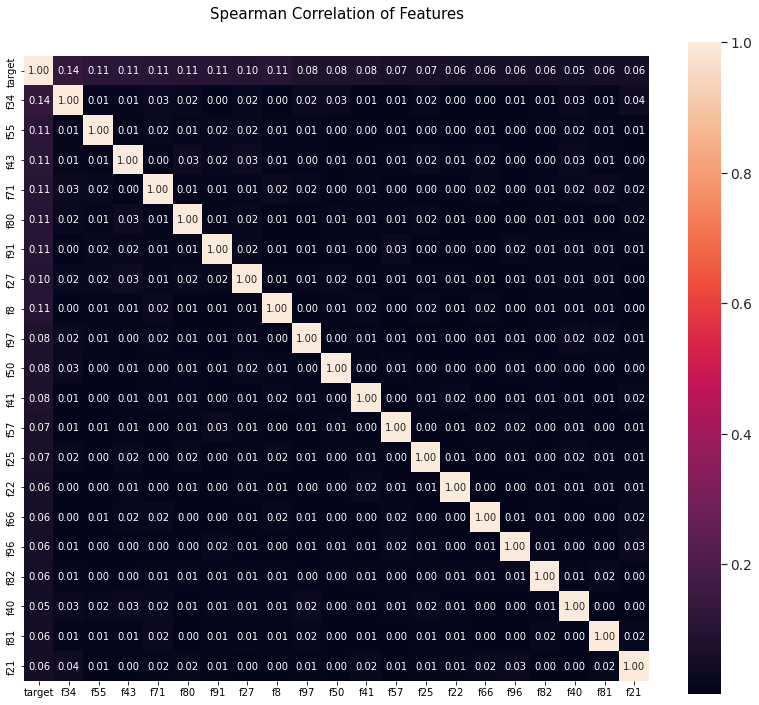

In [18]:
predictors_amount = 20 + 1  # should div by 4  + 1

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Spearman Correlation of Features', y=1.05, size=15)
corrmat = train.corr(method='spearman').abs()
cols = corrmat.nlargest(predictors_amount, target)[target].index
cm = abs(np.corrcoef(train[cols].values.T))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
most_correlated = list(set(cols) - set([target]))

<Figure size 432x288 with 0 Axes>

Creating legend with loc="best" can be slow with large amounts of data.


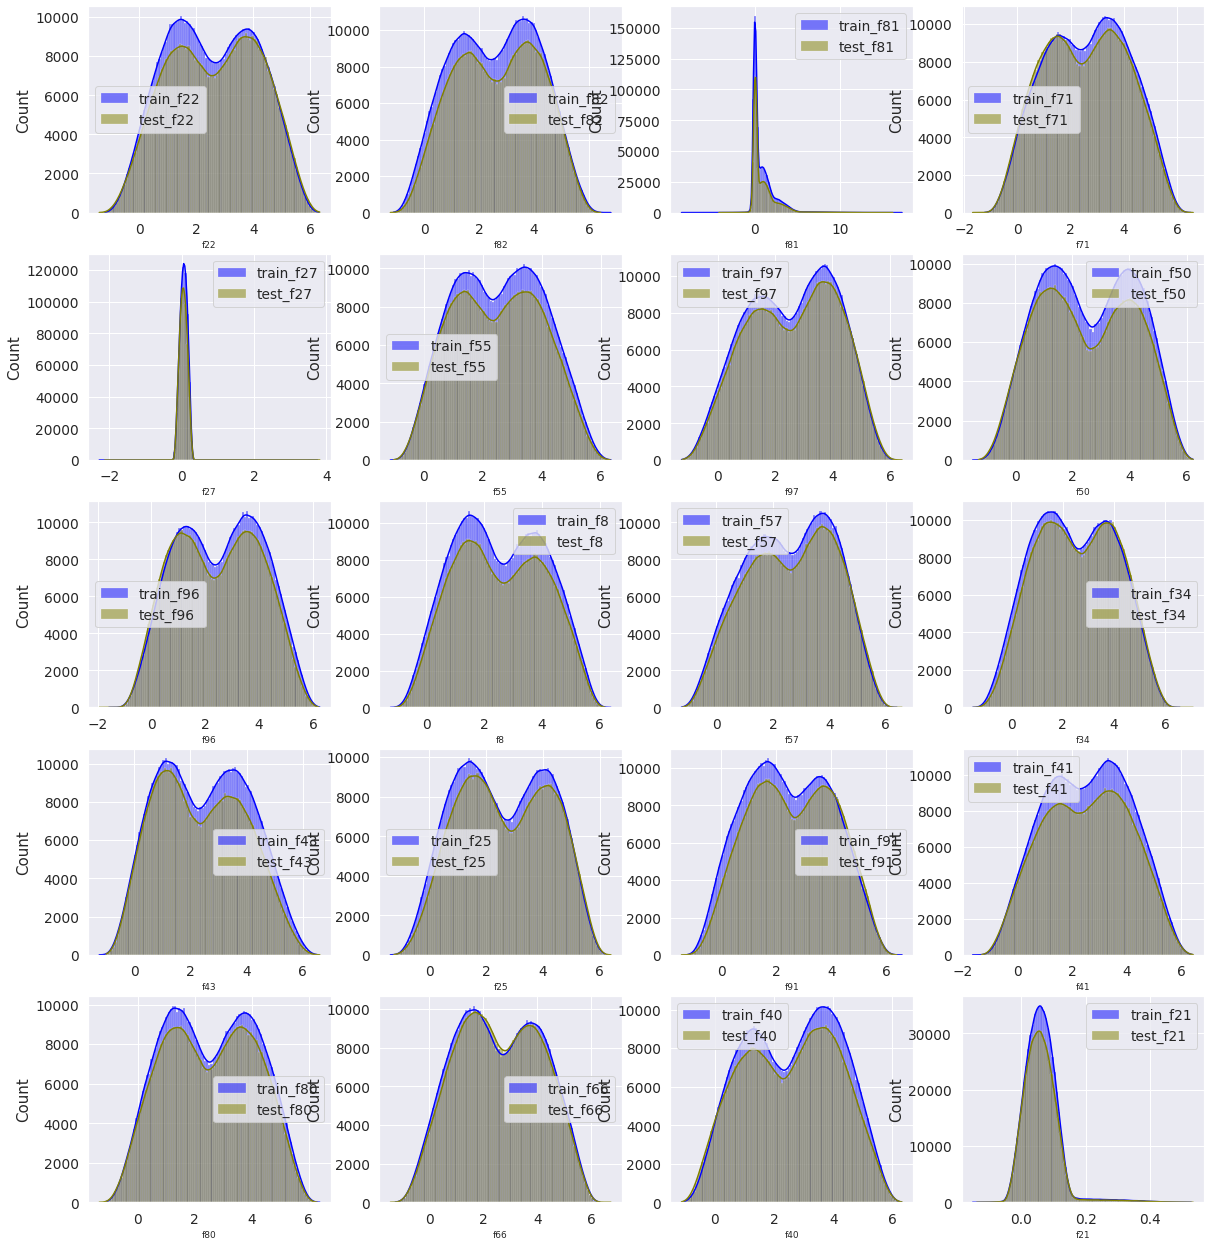

In [19]:
# plot the first most correlated features 

i = 1
cols_amount = 4
rows_amount = int(len(most_correlated) / cols_amount) 
plt.figure()
fig, ax = plt.subplots(rows_amount, cols_amount, figsize=(20, 22))
for feature in most_correlated:
    plt.subplot(rows_amount, cols_amount, i)
    sns.histplot(train[feature],color="blue", kde=True, bins=100, label='train_'+feature)
    sns.histplot(test[feature],color="olive", kde=True, bins=100, label='test_'+feature)
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

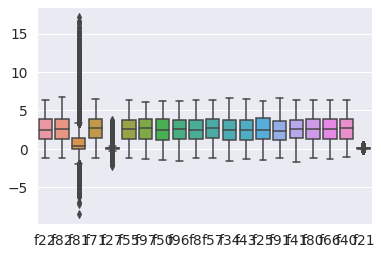

In [20]:
sns.boxplot(data=train[most_correlated])

### Feature preprocessing

In [10]:
columns = train.columns
preproc = dict()
preproc['target'] = target

In [11]:
to_drop = [target]


#### Set categorical columns

In [12]:
categoricals_features = []

#### Select features

In [13]:
features = [col for col in train.columns if col not in to_drop ]
preproc['features'] = features

#### Select column names with <80% missing values

In [14]:
cols_large_miss_val = train[features].columns[(train[features].isnull().mean() > 0.8)]
features = [col for col in features if col not in cols_large_miss_val]
preproc['features'] = features

#### Collinear (highly correlated) features

In [49]:
# Threshold for removing correlated variables
threshold = 0.90
# Absolute value correlation matrix
corr_matrix = train[features].corr(method='spearman').abs()
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Select columns with correlations above threshold
highly_correlated = [column for column in upper.columns if any(upper[column] > threshold)]
features = [col for col in features if col not in highly_correlated]
preproc['features'] = features

#### Zero standard deviation

In [15]:
threshold = 0
zero_std = train[features].std().index[train[features].std() <= threshold]
features = [col for col in features if col not in zero_std]    
preproc['features'] = features

#### Zero coefficient of variantion

In [16]:
threshold = 1  # in %
zero_cv = (100 * train[features].std() / train[features].mean()).index[(100 * train[features].std() / train[features].mean()) <= threshold]
features = [col for col in features if col not in zero_cv]
preproc['features'] = features

#### Scaler transform

In [17]:
scaler = RobustScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])
preproc['scaler'] = scaler

#### Power transform

In [18]:
if 0:
  pt = PowerTransformer()
  pt.fit(train[features])
  train[features] = pt.transform(train[features])
  test[features] = pt.transform(test[features])
  preproc['power_transformer'] = pt

#### Distribution Plots with changes

In [19]:
# plot the first most correlated features 

i = 1
cols_amount = 4
rows_amount = int(len(most_correlated) / cols_amount) 
plt.figure()
fig, ax = plt.subplots(rows_amount, cols_amount, figsize=(20, 22))
for feature in most_correlated:
    plt.subplot(rows_amount, cols_amount, i)
    sns.histplot(train[feature],color="blue", kde=True, bins=100, label='train_'+feature)
    sns.histplot(test[feature],color="olive", kde=True, bins=100, label='test_'+feature)
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

NameError: ignored

## Classic ML baselines

#### Data split

In [54]:
features = preproc['features']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train[target],
                                                    stratify=train[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [34]:
clfs = {
        'Logistic Regression': LogisticRegression(random_state=0), 
        'Naive Bayes': GaussianNB(),
        #'SVM': SVC(gamma='auto'),
        #'Random Forest': RandomForestClassifier(random_state=0),
        'SGD Classifier': SGDClassifier(random_state=0),
        'Ridge': RidgeClassifier(random_state=0),
        'Passive Aggressive Classifier': PassiveAggressiveClassifier(random_state=0),
        #'KNN': KNeighborsClassifier(),
        #'MLP': MLPClassifier(),
        'Decision Tree': DecisionTreeClassifier()
       }

In [35]:
for clf_name in clfs:   
    clf = clfs[clf_name].fit(X_train, y_train)
    y_pred = clf.predict(X_test)   
    print(f'{clf_name}: F1 = {f1_score(y_test, y_pred)}, AUC = {roc_auc_score(y_test, y_pred)}, Accuracy = {accuracy_score(y_test, y_pred)}')
    

Logistic Regression: F1 = 0.7415715606133112, AUC = 0.7370822389436326, Accuracy = 0.73718
Naive Bayes: F1 = 0.5052894879393302, AUC = 0.588033510118394, Accuracy = 0.5859866666666667
SGD Classifier: F1 = 0.7206808773238024, AUC = 0.7099765823621895, Accuracy = 0.71032
Ridge: F1 = 0.7412273800157356, AUC = 0.7367845210370585, Accuracy = 0.73688
Passive Aggressive Classifier: F1 = 0.5408762823058908, AUC = 0.5534386762525785, Accuracy = 0.55304
Decision Tree: F1 = 0.5579587743144448, AUC = 0.5533286105548199, Accuracy = 0.5533733333333334


## Modern ML baselines

In [36]:
clfs = {
        'XGBoost': XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),
        'LGB': LGBMClassifier()
       }

In [37]:
for clf_name in clfs:   
    clf = clfs[clf_name].fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{clf_name}: F1 = {f1_score(y_test, y_pred)}, AUC = {roc_auc_score(y_test, y_pred)}, Accuracy = {accuracy_score(y_test, y_pred)}')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:24:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost: F1 = 0.6969951339795128, AUC = 0.6918740845373645, Accuracy = 0.6919733333333333
LGB: F1 = 0.7018255578093306, AUC = 0.6950541023640711, Accuracy = 0.69522


## Baseline model

In [56]:
baseline_model = LogisticRegression(random_state=0)
baseline_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [57]:
preds = baseline_model.predict(test[features])
y_pred = baseline_model.predict(X_test) 
print(f'LR: F1 = {f1_score(y_test, y_pred)}, AUC = {roc_auc_score(y_test, y_pred)}, Accuracy = {accuracy_score(y_test, y_pred)}')

LR: F1 = 0.7415715606133112, AUC = 0.7370822389436326, Accuracy = 0.73718


In [58]:
sub['target'] = preds
sub.to_csv(path_to_data + 'submission_bl.csv', index=False)

#### intermediate conclusion

Baseline Logistic regression model gives us 0.734 on LB, which is within 95% of max LB result (0.75091)

## Add new features using XGBoost and SHAP

In [18]:
train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof.shape

(600000,)

In [19]:
xgb_params= {
        "objective": "binary:logistic",
        "eval_metric": "error",  
        "seed": 2001,
        'tree_method': "gpu_hist",
        'predictor': 'gpu_predictor'
    }

In [20]:
test_xgb = xgb.DMatrix(test[features])

In [21]:
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train[features], train[target]))):
        #print(f'Fold {f}')
        train_df, val_df = train[features].iloc[train_ind], train[features].iloc[val_ind]
        train_target, val_target = train[target].iloc[train_ind], train[target].iloc[val_ind]
                      
        train_df = xgb.DMatrix(train_df, label=train_target)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model =  xgb.train(xgb_params, train_df, 100)
        temp_oof = model.predict(val_df)
        temp_test = model.predict(test_xgb)

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(accuracy_score(np.round(temp_oof), val_target))

0it [00:00, ?it/s]

0.693425
0.6932916666666666
0.6910166666666666
0.6918166666666666
0.6912916666666666


In [63]:
%%time
shap_preds = model.predict(test_xgb, pred_contribs=True)

CPU times: user 23.2 s, sys: 70.1 ms, total: 23.3 s
Wall time: 23.1 s


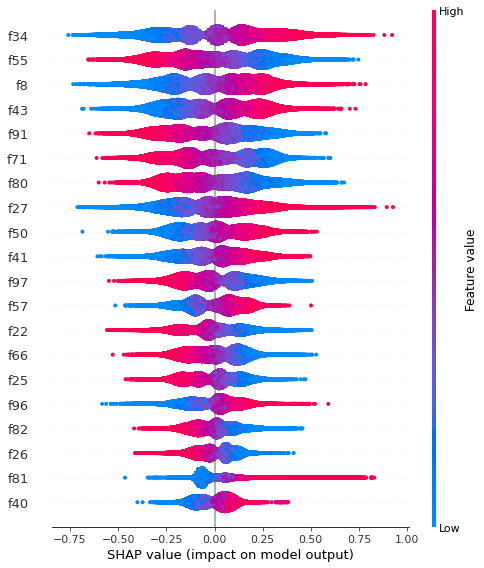

In [64]:
# summarize the effects of all the features
shap.summary_plot(shap_preds[:,:-1], test[features])

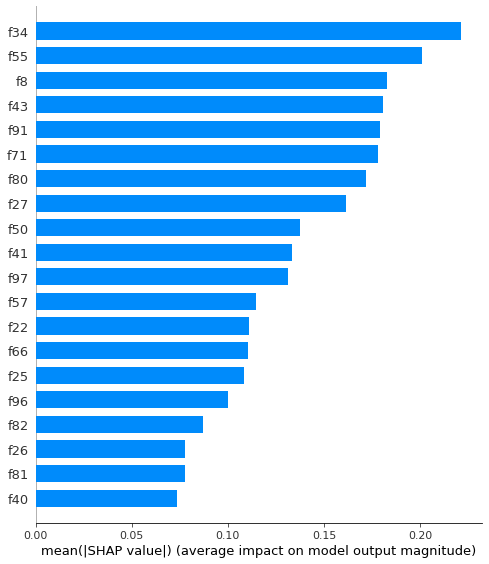

In [65]:
shap.summary_plot(shap_preds[:,:-1], test[features], plot_type="bar")

In [22]:
%%time
shap_interactions = model.predict(xgb.DMatrix(test[features][:50000]), pred_interactions=True)

CPU times: user 28.9 s, sys: 1.7 s, total: 30.6 s
Wall time: 30.5 s


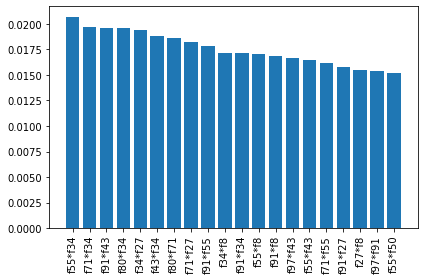

In [23]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "*" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return interaction_features

interactions_to_add = 20    
interaction_features = plot_top_k_interactions(features, shap_interactions, interactions_to_add)

In [24]:
def add_new_features(df, interaction_features, amount_of_features):
    features_list = interaction_features[:amount_of_features]
    for feat in features_list: 
      first_name, second_name = feat.split('*')
      df[feat] = df[first_name]*df[second_name]
    return df, features_list

In [25]:
train, features_added = add_new_features(train, interaction_features, interactions_to_add)
test, _ = add_new_features(test, interaction_features, interactions_to_add)
features += list(features_added)

del test_xgb
del shap_interactions
gc.collect()

In [26]:
features_added

('f55*f34',
 'f71*f34',
 'f91*f43',
 'f80*f34',
 'f34*f27',
 'f43*f34',
 'f80*f71',
 'f71*f27',
 'f91*f55',
 'f34*f8',
 'f91*f34',
 'f55*f8',
 'f91*f8',
 'f97*f43',
 'f55*f43',
 'f71*f55',
 'f91*f27',
 'f27*f8',
 'f97*f91',
 'f55*f50')

#### Scaler transform

In [27]:
scaler = RobustScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])
preproc['scaler'] = scaler

## Baseline model with added features

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train[target],
                                                    stratify=train[target], 
                                                    test_size=0.25, 
                                                    random_state=42)

In [29]:
baseline_model_af = LogisticRegression(random_state=0)
baseline_model_af.fit(X_train, y_train)
preds = baseline_model_af.predict(test[features])
y_pred = baseline_model_af.predict(X_test) 
print(f'LR: F1 = {f1_score(y_test, y_pred)}, AUC = {roc_auc_score(y_test, y_pred)}, Accuracy = {accuracy_score(y_test, y_pred)}')

LR: F1 = 0.7409735390025785, AUC = 0.7367197573584828, Accuracy = 0.7368066666666667


In [30]:
sub['target'] = preds
sub.to_csv(path_to_data + 'submission_blaf.csv', index=False)

## Hyperparameters tuning (Optuna)

In [31]:
# HPO using opuna

def lr_objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-8, 1000.0),        
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']), 
        'random_state': 42,
        'penalty' : 'l2',         
    }
    
    X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size = 0.25, random_state = 42)
    
    model = LogisticRegression(**params)    
    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)
    
    return roc_auc_score(y_val, pred_val)

In [33]:
sampler = TPESampler(seed = 42)
study = optuna.create_study(study_name = 'LR optimization',
                            direction = 'maximize',
                            sampler = sampler)
study.optimize(lr_objective, n_trials = 10)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

[I 2021-11-24 12:49:29,138] A new study created in memory with name: LR optimization
[I 2021-11-24 12:49:38,846] Trial 0 finished with value: 0.7374205683225661 and parameters: {'C': 0.00013180785949353034, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7374205683225661.
[I 2021-11-24 12:49:49,347] Trial 1 finished with value: 0.7384559860175036 and parameters: {'C': 0.038480732119896804, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.7384559860175036.
[I 2021-11-24 12:49:53,208] Trial 2 finished with value: 0.5328685452609957 and parameters: {'C': 4.354313899755652e-08, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.7384559860175036.
[I 2021-11-24 12:50:20,952] Trial 3 finished with value: 0.7384494025656682 and parameters: {'C': 0.6148913105232171, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7384559860175036.
[I 2021-11-24 12:50:31,569] Trial 4 finished with value: 0.7384625694693392 and parameters: {'C': 14.350566608281152, 'solver': 'lbfgs'}. Best is trial 4 with

Best AUC: 0.7388204453136863
Best params: {'C': 0.0005641507957507974, 'solver': 'liblinear'}


In [34]:
if 1:
    params = study.best_params
else:
    params = {'C': 0.00045858194103088424, 'solver': 'liblinear'}

## Cross-validation with optimized params


--------------- > Fold 1 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.73605
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

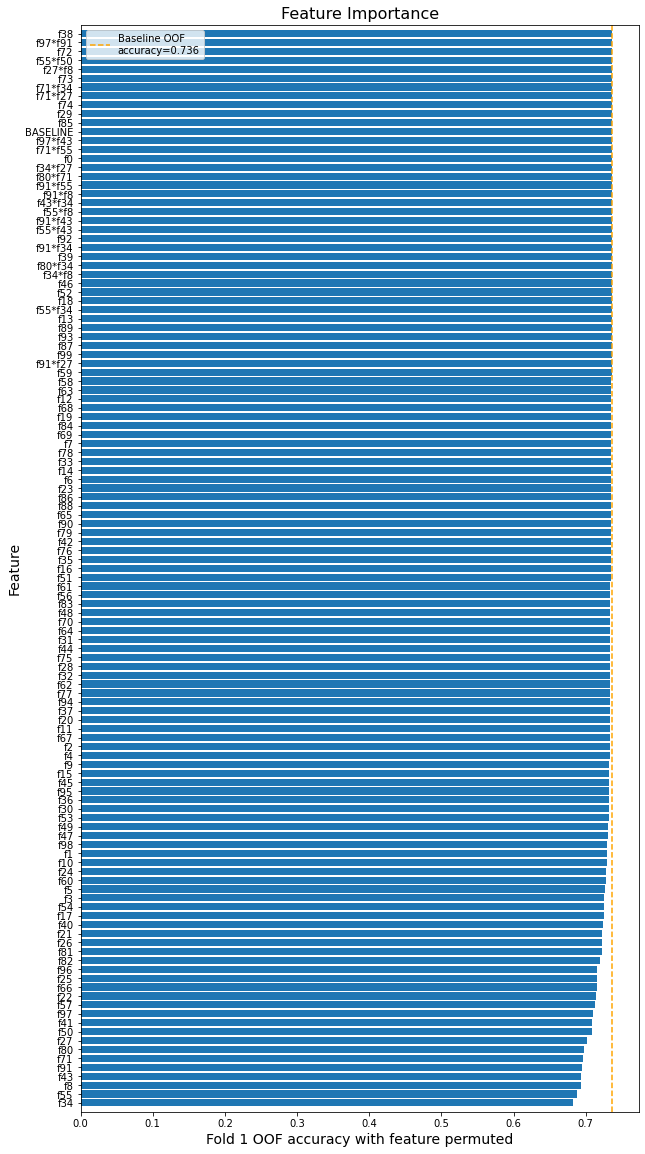

--------------- > Fold 2 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7367166666666667
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

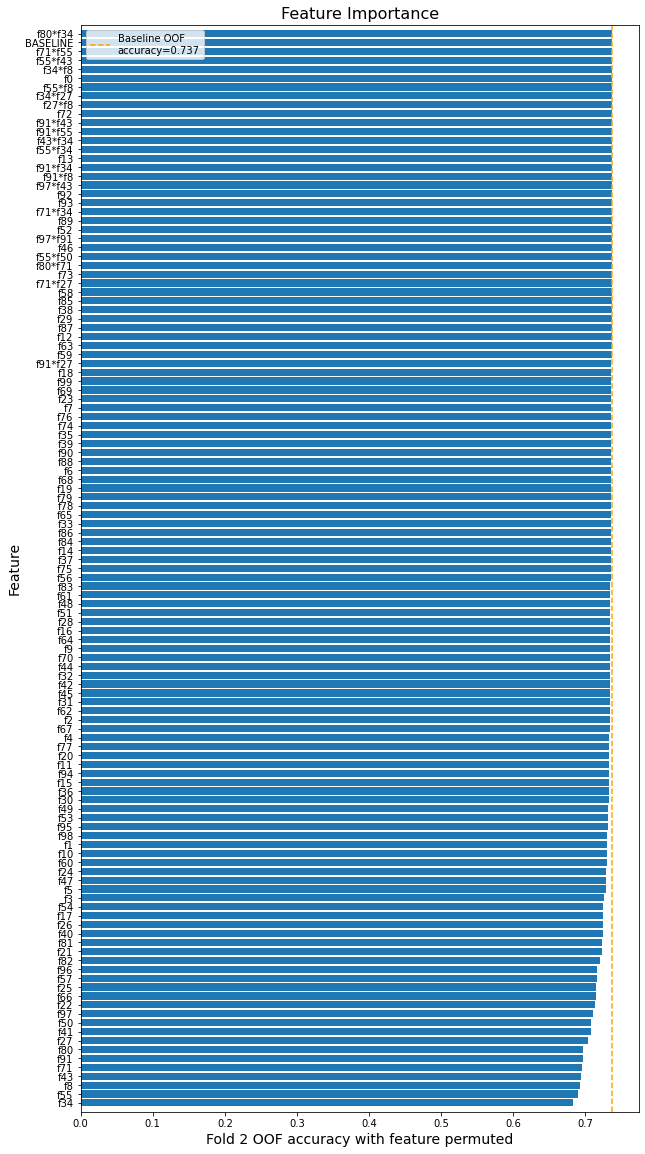

--------------- > Fold 3 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7341
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

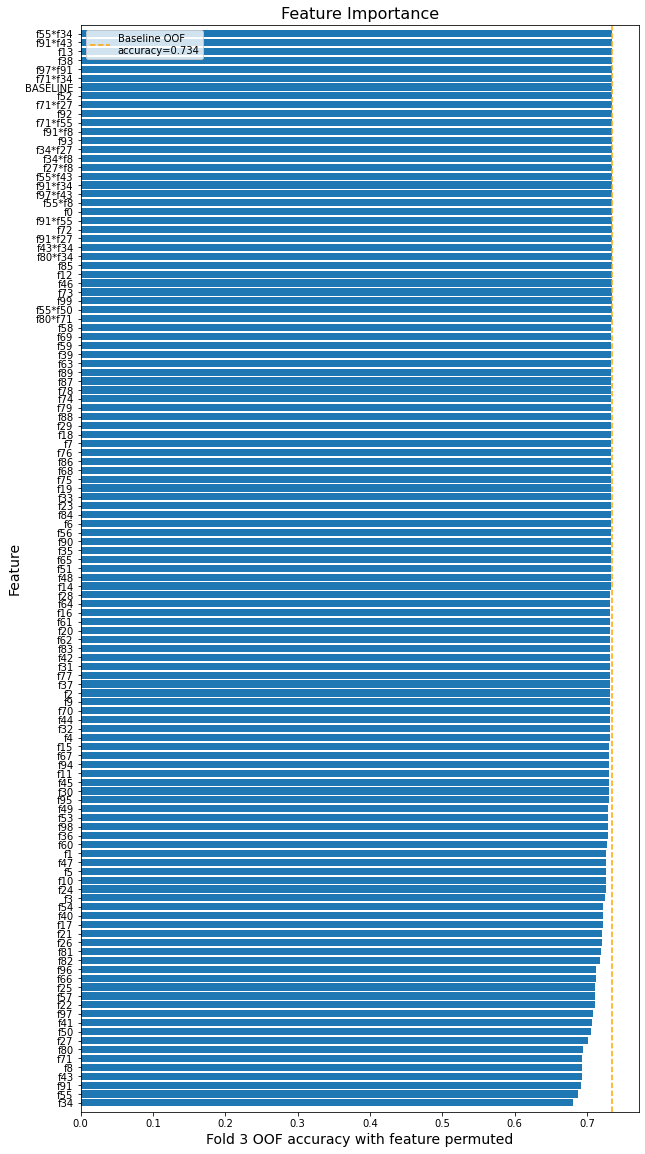

--------------- > Fold 4 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7371833333333333
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

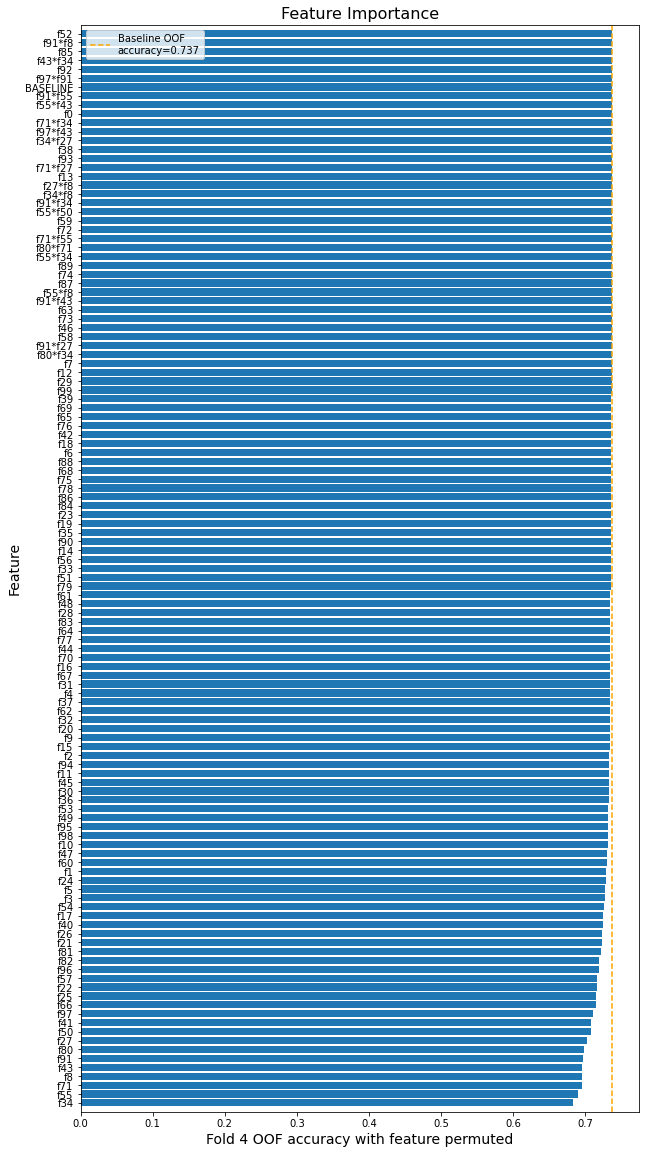

--------------- > Fold 5 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7355
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

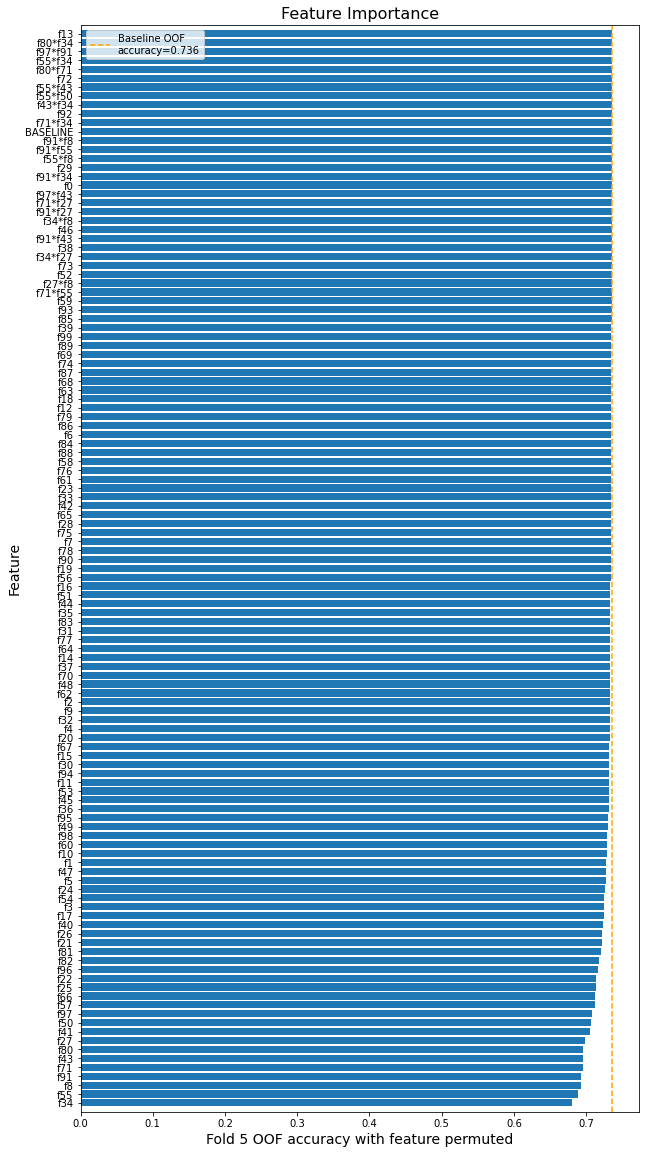

--------------- > Fold 6 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.74045
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

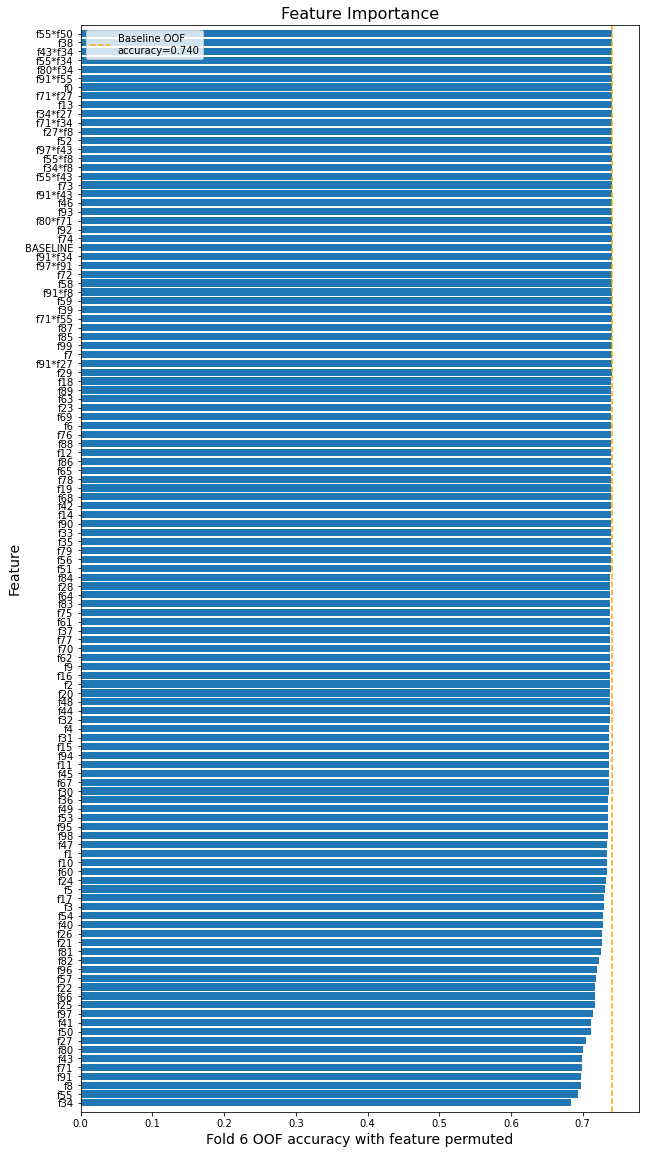

--------------- > Fold 7 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7371333333333333
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

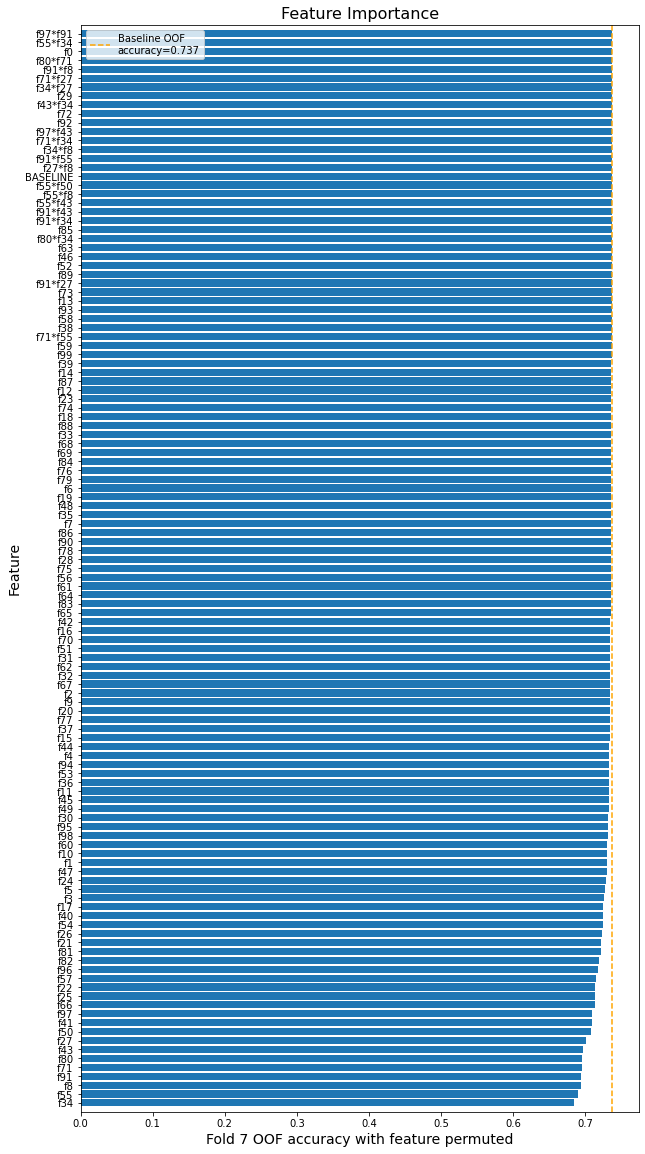

--------------- > Fold 8 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7396333333333334
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

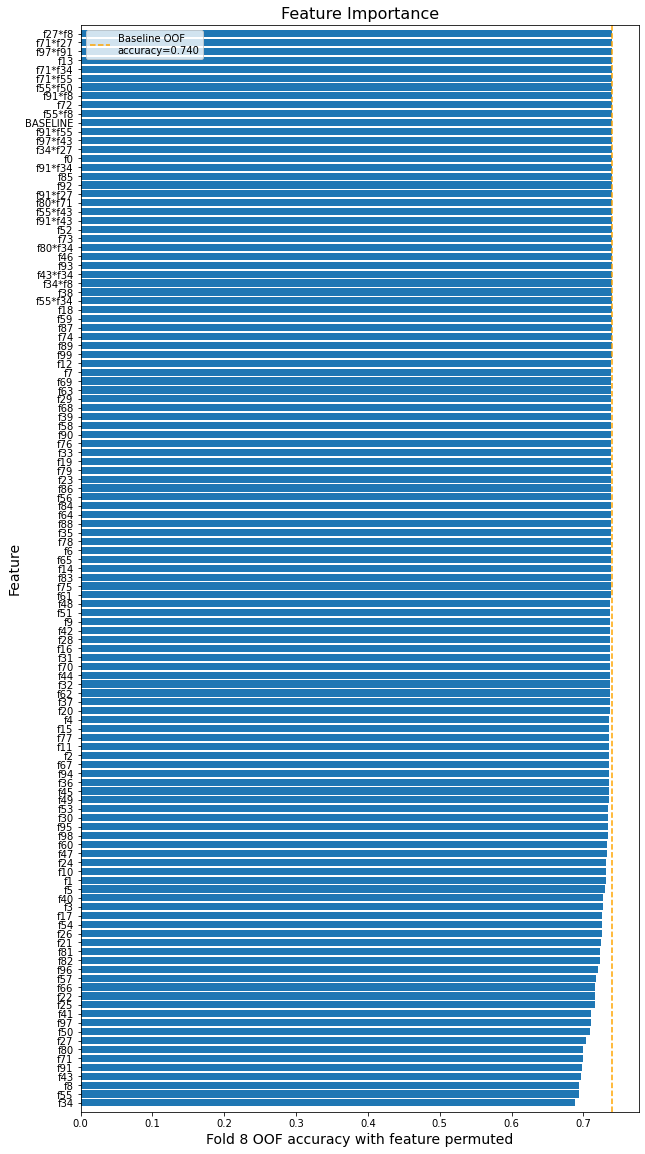

--------------- > Fold 9 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7363166666666666
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

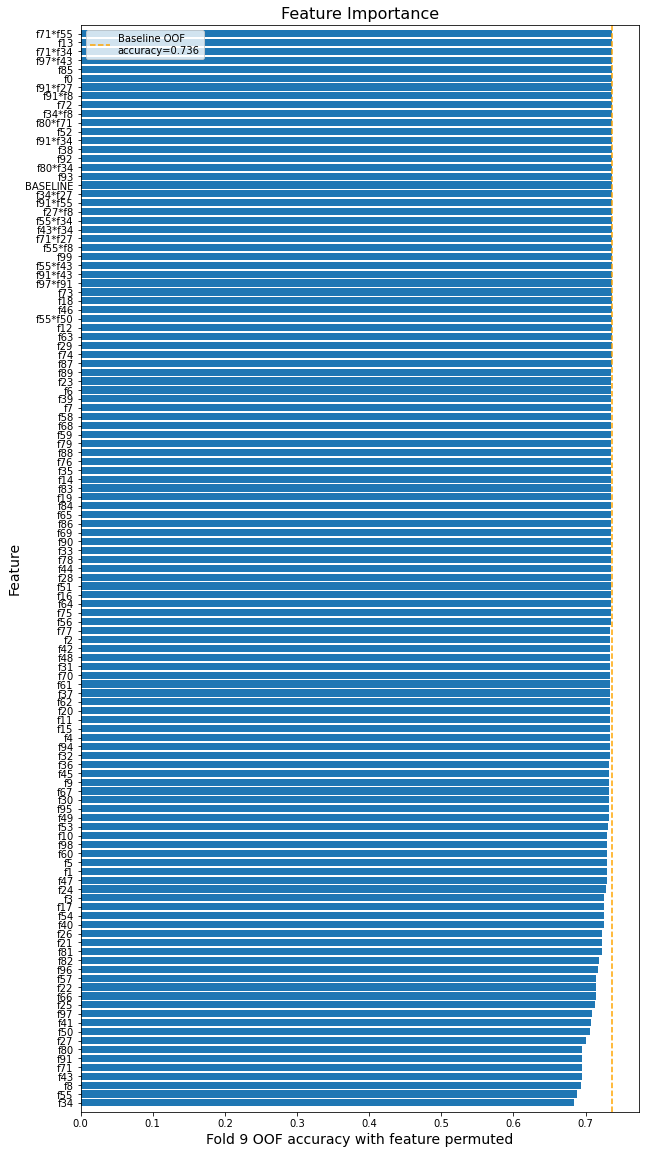

--------------- > Fold 10 < ---------------
 Predicting OOF data...
OOF Accuracy = 0.7406
 Done!
 Predicting test data...
 Done!
 Computing feature importance...


  0%|          | 0/120 [00:00<?, ?it/s]

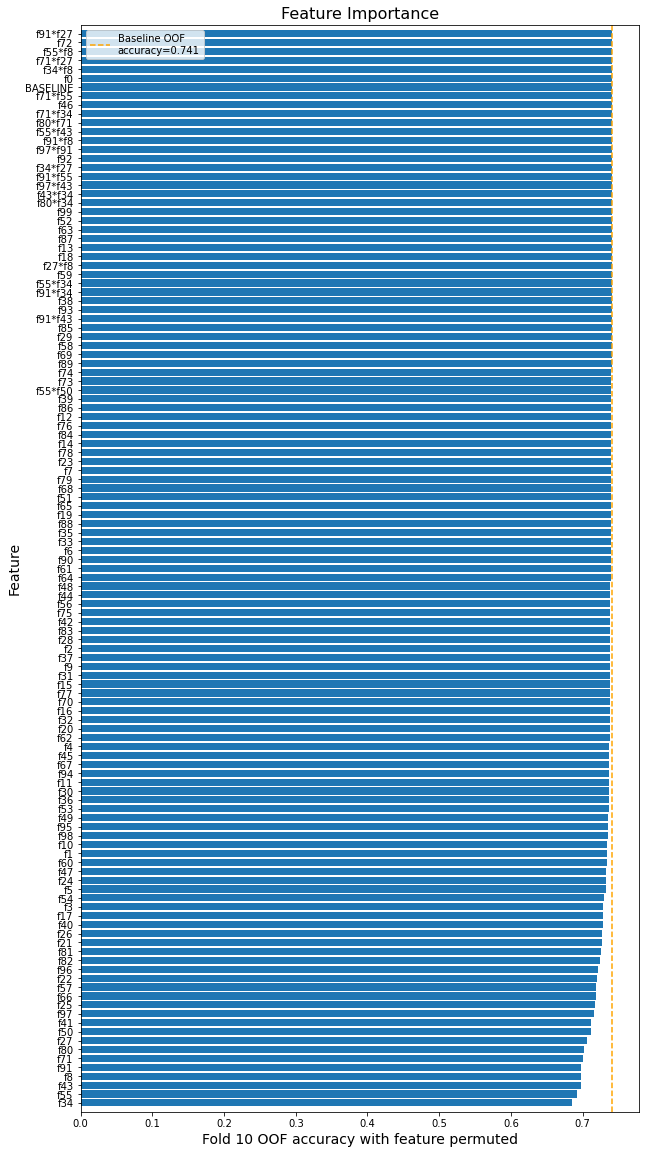

In [35]:
#EPOCH = 250
#BATCH_SIZE = 512
NUM_FOLDS = 10
COLS = features.copy()

kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
test_preds = []
oof_preds = []
for fold, (train_idx, test_idx) in enumerate(kf.split(train[features], train[target])):
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[features].iloc[train_idx], train[features].iloc[test_idx]
        y_train, y_valid = train[target].iloc[train_idx], train[target].iloc[test_idx]
        
        filename = f"folds{fold}.pkl"
        
        if TRAIN_MODEL:
            #model = LogisticRegression(C = params['C'], solver = params['solver'])
            model = LogisticRegression(**params)
            model.fit(X_train, y_train)
            pickle.dump(model, open(path_to_data + filename, 'wb'))                                    
            
        else:                  
            model = pickle.load(open(path_to_data + filename, 'rb'))                  
    
        if OOF:
            print(' Predicting OOF data...')                
            oof = model.predict(X_valid)
            baseline_accuracy = accuracy_score(y_valid, oof)            
            oof_preds.append(baseline_accuracy)
            print('OOF Accuracy = {0}'.format(baseline_accuracy))
            print(' Done!')
                       
        if INFER_TEST:
            print(' Predicting test data...')
            preds = model.predict(test[features])
            test_preds.append(np.array(preds))
            print(' Done!')
                    
        if COMPUTE_IMPORTANCE:
            # from  https://www.kaggle.com/cdeotte/lstm-feature-importance
            results = []
            print(' Computing feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof = model.predict(X_valid)
            baseline_accuracy = accuracy_score(y_valid, oof)
            results.append({'feature':'BASELINE','accuracy':baseline_accuracy})
                                    
            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid.copy()
                np.random.shuffle(X_valid[COLS[k]].values)
                                
                # COMPUTE OOF Accuracy WITH FEATURE K SHUFFLED
                oof = model.predict(X_valid)
                acc = accuracy_score(y_valid, oof)
                results.append({'feature':COLS[k],'accuracy':acc})                               
                
                X_valid = save_col.copy()
         
            # DISPLAY FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('accuracy')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.accuracy)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_accuracy,baseline_accuracy],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\naccuracy={baseline_accuracy:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF accuracy with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('accuracy',ascending=False)
            df.to_csv(f'feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

In [36]:
print('Mean of OOF: {0}, StD of OOF: {1}'.format(np.mean(oof_preds), np.std(oof_preds)))

Mean of OOF: 0.7373683333333332, StD of OOF: 0.0020640097168160808


### Plot of roc curve for the last fold

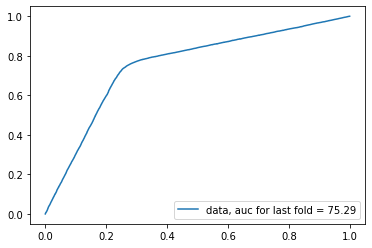

In [37]:
y_pred_proba = model.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_valid,  y_pred_proba)
auc = metrics.roc_auc_score(y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc for last fold = " + str(round(auc*100,2)))
plt.legend(loc=4)
plt.show()

### Submission prepare

In [38]:
sub['target'] = sum(test_preds) / NUM_FOLDS
sub.to_csv(path_to_data + 'submission.csv', index=False)